*** This script is an attempted to do structured learning on the building permits based on the subtypes previously inferred by the unsupervised clustering step ***

Briefly, this impllies performing the following steps:

1) Read the permit subtypes and their associated 'synonym' words. 

2) Determine the subtypes for each permit (i.e. the class labels of each permit to be used in the Naive Bayes step). This step produces y_train. Note that this mapping is not 1-1 as a permit may belong to multiple permit subtypes.

3) Vecotrize the building permits and construct a tf/idf matrix from the building permit training set. This produces the x_train features.

3) We build a Chou-Liu graph across the y_train labels. This is a maximum spanning tree graph across the labels which will serve as the inference step of the structured modeling (i.e. determines the space to be explored). 

4) Train a Multilabel SVM (model) with a NSlackSVVM (learner).

5) Open the "gold standard" testing set and determine the error from the classifiers built previously. For the overall error, we consider a "misclassification" if any of the 60 class is incorrectly assigned for each permit.

General declarations, including used libraries, support and plotting packages.
Python version 2.7+ must be installed along with the following packages:
os (built-in), numpy, pandas, nltk (Natural Language Processing Toolkit), codecs, sklearn (statistical learning package), mpld3, MySQLdb, pylab, csv, string, matplotlib (plotting), wordcloud (only if word clouds plotting is desired), seaborn (plotting), pickle (to save clusters and other data objects).

In [268]:
import numpy as np
import numpy as N, networkx as nx
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import MySQLdb
import pandas.io.sql as sql
import matplotlib.pyplot as plt
import pylab as py
import csv
import string
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from pystruct.learners import NSlackSSVM
from pystruct.models import MultiLabelClf
from collections import defaultdict

import seaborn as sns
import pickle

sns.set(style="white", color_codes=True)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

stopwords=set(unicode("john american james hbcode thomas david michael robert subtype richard permit building none america rochester william needs brother jessica give like send estimate im youre chat details regarding hi available email call please interested contact looking project need job phone work so some somebody somehow someone something sometime sometimes somewhat somewhere soon sorry specified specify specifying still sub such sup sure t's take taken tell tends th than thank thanks thanx that that's thats the their theirs them themselves then thence there there's thereafter thereby therefore therein theres thereupon these they they'd they'll they're they've think third this thorough thoroughly those though three through throughout thru thus to together too took toward towards tried tries truly try trying twice two un under unfortunately unless unlikely until unto up upon us use used useful uses using usually value various very via viz vs want wants was wasn't way we we'd we'll we're we've welcome well went were weren't what what's whatever when whence whenever where where's whereafter whereas whereby wherein whereupon wherever whether which while whither who who's whoever whole whom whose why will willing wish with within without won't wonder would wouldn't yes yet you you'd you'll you're you've your yours yourself yourselves zero a about above after again against all am an and any are aren't as at be because been before being below between both but by can can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on one once only or other ought our ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves").split())


General functions for reading data, doing cluster to keyword mapping and text pre-processing.

In [2]:
# Function to read the raw text from the curated building permit sample files
# Input: input_file, which is simply a string with the file name
# Output: list where each element is the raw text from each building permit. 
def read_curated(input_file):
    text=[]
    with open(input_file, 'rU') as f:
        reader = csv.reader(f,delimiter='\t')
        # For each row in the file, read the job_values and the associated strings. 
        for row in reader:
            text.append(' '.join(row))
    return text

# Function to read words associated to clusters or permit subtype
# Input: file_name
# Output: list of identifier for each trade/permit type (label), list of 'synonym' words for each permit subtype. 
def read_words(input_file):
    label=[]
    words=[]
    with open(input_file, 'rU') as f:
        reader = csv.reader(f,delimiter='\n')
        # For each row in the file, read the job_values and the associated strings. 
        for row in reader:
            row=row[0].split(',')
            label.append(row.pop(0))
            temp=[]
            for x in row:
                x=x.lower()
                x=x.replace('"','')
                x=x.replace(' ','')
                if x != '':
                    temp.append(x)
            words.append(temp)
    return label,words

# Function to read BuildZoom building permits from a saved filed.
# Inputs: file name that has the data
def read_permit(input_file):
    # List that will hold the job_values (val) and the text from the data (a)
    a=[]
    val=[]
    with open(input_file, 'rU') as f:
        reader = csv.reader(f,delimiter='\t')
        # For each row in the file, read the job_values and the associated strings. 
        for row in reader:
            # Ignore rows that do not have the id(from pandas) + 6 queried features (can be NULL too)
            if len(row) == 7:
                # Remove the pandas id (just trash from the pandas dataframe)
                row.pop(0)
                try: 
                    # Save the job_value for each building permit if the value is a valid integer
                    val.append(float(row.pop(0)))
                except:
                    # Simply ignore and place a zero value, if not
                    val.append(0)
                # Save building permit text
                a.append(row)
    return val,a

# Function to join text for a given list. 
# Inputs: list with strings
def join_txt(x):
    content = ' '.join(filter(None,x))
    return content

# Text pre-processing function, that also applies the Snowball stemmer to each word
# This function's only difference compared to content2tokens is the use of the stemmer. 
# Filter out spaces, punctuation, unnecessary whitespaces. 
# Any stop-word is also removed
# Additionally, this function also removes any word smaller than 4 characters
# Inputs: list with string for each building permit
def content2stems(s):
    # Initialize Snowball stemmer
    stemmer = SnowballStemmer("english")
    # Transform all letters to lower-case
    content = s.lower()
    # Remove periods
    content = content.replace('.', ' ')    
    # Split words
    content = ' '.join(content.split())
    # Remove punctuation
    for c in content:
        if c in string.punctuation or c.isdigit():
            content=content.replace(c," ")
    
    # Split words into a list
    content = content.split() 
    # Filter words from the stoplist
    content = filter(lambda w: w not in stopwords, content)  
    # Filter words smaller than 3 characters
    content = filter(lambda w: len(w) > 3, content)
    # Apply Snowball stemmer to words
    content = [stemmer.stem(t) for t in content]    
    return content

# Function to label permit subtypes to individual samples using the cluster assignements
# Input: permit raw text (permits), list of keywords associated to each subtype and label for each subtype
# Output: matrix were rows are samples and columns are subtype assignments (1: positive, 0: negative)
def sample_mapping(permits,keyword_map,labels):
    sample_map=[]
    for s in permits:
        # Stem the building permit
        permit_stem= content2stems(s)
        
        # Determine the subtypes of the stemmed permit
        intersect_list = [filter(lambda x: x in permit_stem, sublist) for sublist in keyword_map]
        sample_map.append([1 if len(x) > 0 else 0 for x in intersect_list])
        
    return pd.DataFrame(sample_map,columns=labels)

# Function to stem the keywords associated to building permit subtypes
# Input: list of building subtypes in which each list has a list of keywords associated to that subtype
# Outputs: list of building subtypes in which each list has a list of 
def stem_keywords(keyword_list):
    stemmer = SnowballStemmer("english")
    keyword_stems=[]
    # For every list of keywords associated to a building permit, stem all keywords
    for l in keyword_list:
        l=map(lambda x: stemmer.stem(x),l)
        # Eliminate potential duplicates
        l=list(set(l))
        keyword_stems.append(l)
    
    return keyword_stems

# Function to calculate marginal distributions across an arrray
# Return the marginal distribution for the u'th features of the data points, X.
def marginal_distribution(X, u):
    values = defaultdict(float)
    s = 1. / len(X)
    for x in X:
        values[x[u]] += s
    return values


# Function to calculate a pair marginal distribution across an array
# Return the marginal distribution for the u'th and v'th features of the data points, X.
def marginal_pair_distribution(X, u, v):
    if u > v:
        u, v = v, u
    values = defaultdict(float)
    s = 1. / len(X)
    for x in X:
        values[(x[u], x[v])] += s
    return values


# Function to calculate mutual information across an array 
# X are the data points.
# u and v are the indices of the features to calculate the mutual information for.
def calculate_mutual_information(X, u, v):
    if u > v:
        u, v = v, u
    marginal_u = marginal_distribution(X, u)
    marginal_v = marginal_distribution(X, v)
    marginal_uv = marginal_pair_distribution(X, u, v)
    I = 0.
    for x_u, p_x_u in marginal_u.iteritems():
        for x_v, p_x_v in marginal_v.iteritems():
            if (x_u, x_v) in marginal_uv:
                p_x_uv = marginal_uv[(x_u, x_v)]
                I += p_x_uv * (N.log(p_x_uv) - N.log(p_x_u) - N.log(p_x_v))
    return I

# Function to build the Chow-Liu Tree from an array
# Build a Chow-Liu tree from the data, X. This array must have sample on the rows and features in the columns
# n is the number of features. The weight on each edge is
# the negative of the mutual information between those features. The tree is returned as a networkx
# object converted into a numpy matrix (we multiply by -1 at the end to return a maximum spanning tree)
def build_chow_liu_tree(X):
    n = len(X[0])
    G = nx.Graph()
    for v in xrange(n):
        G.add_node(v)
        for u in xrange(v):
            G.add_edge(u, v, weight=-calculate_mutual_information(X, u, v))
    T = nx.minimum_spanning_tree(G)
    return T

Read the keywords associated to each building permit subtype and then stem them.

In [3]:
# Read building permit subtypes keywords and stem them.
keyword_label,keywords=read_words('taxonomy_cluster_keywords.csv')
keywords_stems=stem_keywords(keywords)

Read "gold" standard testing set that was created earlier, to use as an evaluation metric for the classifiers that will be tested

In [4]:
permits_curated=read_curated('./Curated_Permits/BPermit_Curated_Sample.tsv')
map_test=pd.DataFrame.from_csv('./Curated_Permits/Curated_Class_Labels.csv')

Read all building permits to be used for training, stem them and related them to the building subtypes.

In [5]:
# Read input files and format original data
job_values, build_permits=read_permit('./Data/BPermit_Sample.tsv')
build_permits=map(join_txt,build_permits)
build_permits=map(lambda x : unicode(x, errors='ignore'),build_permits)
# Stem, return
# Use the raw text, apply filters and tokenize. 
map_train=sample_mapping(build_permits,keywords_stems,keyword_label)

Build tf/idf matrix for the training set data and the testing set data (curated data)

In [6]:
# Build tf/idf matrix for the classifiers
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=300,
                                   min_df=50, stop_words=stopwords,
                                   use_idf=True, tokenizer=content2stems, 
                                   decode_error='ignore',ngram_range=[1,1])
tfidf_matrix_train = tfidf_vectorizer.fit_transform(build_permits)
terms = tfidf_vectorizer.get_feature_names()

tfidf_vectorizer_test = TfidfVectorizer(vocabulary=terms, stop_words=stopwords,
                                        use_idf=True, tokenizer=content2stems, 
                                        decode_error='ignore',ngram_range=[1,1])
tfidf_matrix_test = tfidf_vectorizer_test.fit_transform(permits_curated)

tfidf_matrix_train=tfidf_matrix_train.toarray()
tfidf_matrix_test=tfidf_matrix_test.toarray()

# Also convert the permit labels (y, for the predictions) into a numpy array
map_train=np.array(map_train)
map_test=np.array(map_test)

Build Chow-Liu Tree across the training labels, so we may use it for the structured learning step

In [7]:
# Build Tree
CL_Tree = build_chow_liu_tree(map_train)
# Only remove edges from tree
CL_Edges=np.array(CL_Tree.edges(data=True))
CL_Tree=nx.relabel_nodes(CL_Tree,dict(enumerate(keyword_label)))

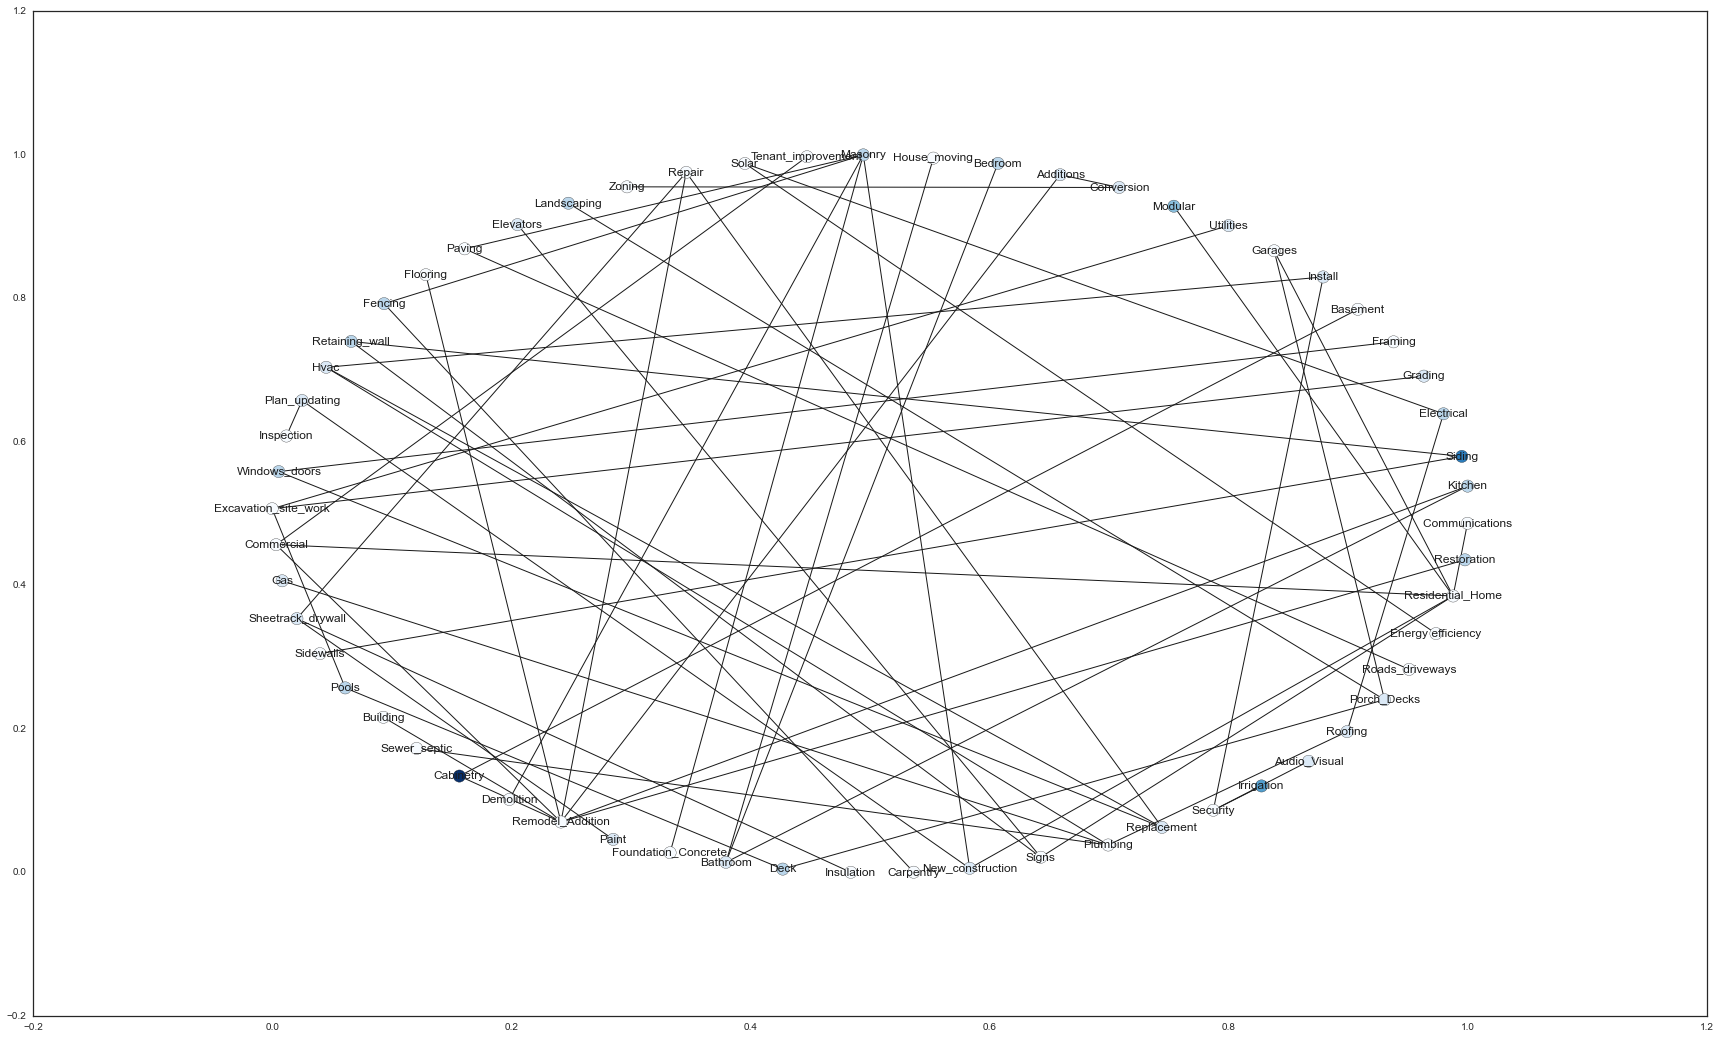

In [285]:
f, ax = plt.subplots(figsize=(30, 18))
position=nx.spring_layout(CL_Tree)
g=nx.draw_networkx_nodes(CL_Tree,pos=position,node_size=150,node_shape='o',node_color=nx.degree(CL_Tree).values(),
                         cmap=plt.get_cmap('Blues'))
g=nx.draw_networkx_edges(CL_Tree,pos=position)
g=nx.draw_networkx_labels(CL_Tree,pos=position)
plt.savefig('./Plots/Chow-Liu_Tree.png')

Build a Structured Learning model using a Multi-label SVM and NSlackSSVM learner

In [ ]:
clf = NSlackSSVM(MultiLabelClf(edges=CL_Edges))

clf.fit(tfidf_matrix_train, map_train)
#clf.predict(tfidf_matrix_test)
#clf.score(tfidf_matrix_test, np.array(map_test))